# HumanForYou

## Téléchargement du GitHub

Le code suivant permet de télécharger les datasets CSV depuis GitHub.

In [53]:
!rm -r sample_data/

rm: cannot remove 'sample_data/': No such file or directory


In [54]:
import os
import requests


DESTINATION_DIRECTORY = "datasets/"
DATASETS_DIRECTORY = "https://raw.githubusercontent.com/achille-garin/Glados/main/datasets/"
DATASETS_NAMES = [
                  "general_data.csv",
                  "employee_survey_data.csv",
                  "manager_survey_data.csv",
                  "in_time.csv",
                  "out_time.csv"
]

def download_csv():
  if not os.path.isdir(DESTINATION_DIRECTORY):
    os.makedirs(DESTINATION_DIRECTORY)
    for name in DATASETS_NAMES:
      destination_path = os.path.join(DESTINATION_DIRECTORY, name)
      r = requests.get(DATASETS_DIRECTORY + name, allow_redirects=True)
      open(DESTINATION_DIRECTORY + name, 'wb').write(r.content)

download_csv()

## Enregistrement des figures

In [55]:
import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIRECTORY = "."
IMAGES_DIRECTORY = "images"

def save_fig(fig_id, tight_layout=True):
  if not os.path.isdir(IMAGES_DIRECTORY):
    os.makedirs(IMAGES_DIRECTORY)
  path = os.path.join(PROJECT_ROOT_DIRECTORY, "images", fig_id + ".png")
  print("Saving figure", fig_id)
  if tight_layout:
      plt.tight_layout()
  plt.savefig(path, format='png', dpi=300)

## Chargement des CSV en mémoire

In [56]:
import pandas as pd

def fetch_row_data(row_data_path=DESTINATION_DIRECTORY):
    if not os.path.isdir(row_data_path):
        os.makedirs(row_data_path)

fetch_row_data()

def load_row_data(_path,filename):
    csv_path = os.path.join(_path,filename)
    return pd.read_csv(csv_path)

general = load_row_data(DESTINATION_DIRECTORY, "general_data.csv")
manager_survey = load_row_data(DESTINATION_DIRECTORY,"manager_survey_data.csv")
employee_survey = load_row_data(DESTINATION_DIRECTORY, "employee_survey_data.csv")
in_time = load_row_data(DESTINATION_DIRECTORY, "in_time.csv")
out_time = load_row_data(DESTINATION_DIRECTORY, "out_time.csv")

## Traitement des données de pointeuse

In [57]:
ID_COL_NAME = 'Unnamed: 0'

employee_ids = in_time.copy()[ID_COL_NAME]
in_time.drop(columns=ID_COL_NAME, inplace=True)
out_time.drop(columns=ID_COL_NAME, inplace=True)

in_time.fillna(np.nan, inplace=True)
out_time.fillna(np.nan, inplace=True)

In [58]:
def remove_holyday(in_time, out_time):
  for col in in_time:
    working_day = in_time[col].any()0.080768
    if not working_day:
      in_time.drop(columns=col, inplace=True)
      out_time.drop(columns=col, inplace=True)

def convert_to_date(in_time, out_time):
  for date in in_time.columns:
    in_time[date]=pd.to_datetime(in_time[date],errors='ignore',format='%Y-%m-%d %H:%M:%S')
    out_time[date]=pd.to_datetime(out_time[date],errors='ignore',format='%Y-%m-%d %H:%M:%S')

def mean_gatherer(in_time, out_time):
  data = []
  for index, serie in in_time.iterrows():
    away_day_count = serie.size - serie.count()
    serie_out = out_time.iloc[index]
    serie = serie.where(serie != np.nan).dropna()
    serie_out.dropna()
    work_time = serie_out - serie
    data.append([work_time.mean().total_seconds()/60/60, away_day_count])
  return pd.DataFrame(data, columns = ['WorkTime', 'AwayDays'])


remove_holyday(in_time, out_time)
convert_to_date(in_time, out_time)
in_out = mean_gatherer(in_time, out_time)
in_out['EmployeeID'] = employee_ids

in_out.head(5)

,WorkTime,AwayDays,EmployeeID
0,7.373651,17,1
1,7.718969,13,2
2,7.013240,7,3
3,7.193678,14,4
4,8.006175,4,5


## Fusion CSV

In [59]:
dataset = general.merge(manager_survey, how='left', on='EmployeeID')
dataset = dataset.merge(employee_survey, how='left', on='EmployeeID')
dataset = dataset.merge(in_out, how='left', on='EmployeeID')

## Nettoyage du Jeu de données

In [60]:
dataset.drop([
              'Age', 
              'Education', 
              'EducationField', 
              'EmployeeCount', 
              'EmployeeID',
              'Gender', 
              'MaritalStatus', 
              'NumCompaniesWorked', 
              'Over18', 
              'StandardHours', 
              'TotalWorkingYears'
              ], 
             axis=1, inplace=True)
dataset.head(5)

,Attrition,BusinessTravel,Department,DistanceFromHome,JobLevel,JobRole,MonthlyIncome,PercentSalaryHike,StockOptionLevel,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,WorkTime,AwayDays
0,No,Travel_Rarely,Sales,6,1,Healthcare Representative,131160,11,0,6,1,0,0,3,3,3.0,4.0,2.0,7.373651,17
1,Yes,Travel_Frequently,Research & Development,10,1,Research Scientist,41890,23,1,3,5,1,4,2,4,3.0,2.0,4.0,7.718969,13
2,No,Travel_Frequently,Research & Development,17,4,Sales Executive,193280,15,3,2,5,0,3,3,3,2.0,2.0,1.0,7.013240,7
3,No,Non-Travel,Research & Development,2,3,Human Resources,83210,11,3,5,8,7,5,2,3,4.0,4.0,3.0,7.193678,14
4,No,Travel_Rarely,Research & Development,10,1,Sales Executive,23420,12,2,2,6,0,4,3,3,4.0,1.0,3.0,8.006175,4


## Histogramme

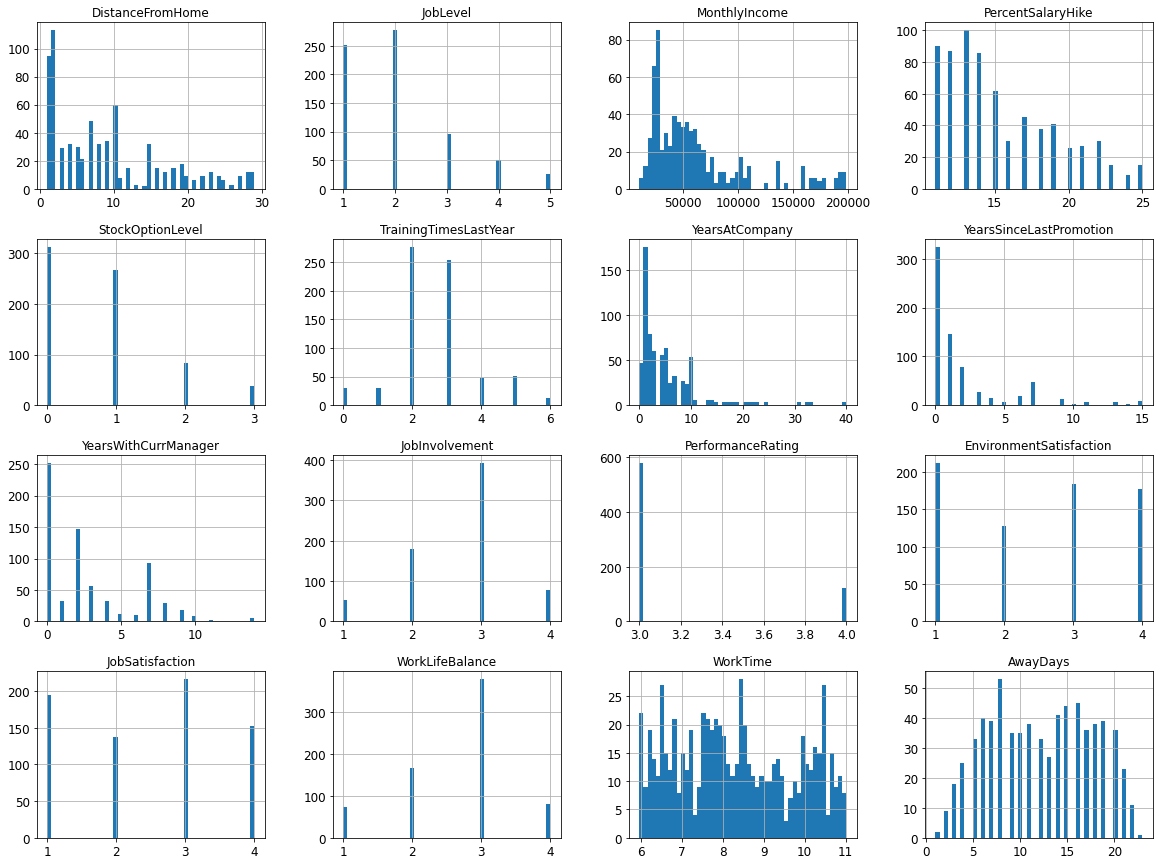

In [61]:
attrition_dataset = dataset.where(dataset['Attrition'] == 'Yes').dropna()
attrition_dataset.hist(bins=50, figsize=(20,15))
plt.show()

## Pipeline quantitative

In [62]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

## Pipeline qualitative

In [63]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer

dataset_num = dataset.select_dtypes(include = [np.number])

num_attribs = list(dataset_num)
cat_dataset = dataset.copy()
for col in num_attribs:
  cat_dataset = cat_dataset.drop(columns=col)
cat_attribs = cat_dataset.columns

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

dataset_prepared = pd.DataFrame(full_pipeline.fit_transform(dataset))

Nous allons maintenant rajouter le nom des colonnes sur le DataFrame.

In [64]:
column_list = num_attribs.copy()
for cat in cat_attribs:
  for subcat in sorted(dataset[cat].unique()):
    column_list.append(subcat)

dataset_prepared.columns = column_list

dataset_prepared.drop(columns='No', inplace=True)
dataset_prepared.rename(columns={'Yes': 'Attrition'}, inplace=True)

dataset_prepared.head(5)

,DistanceFromHome,JobLevel,MonthlyIncome,PercentSalaryHike,StockOptionLevel,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,...,Sales,Healthcare Representative,Human Resources,Laboratory Technician,Manager,Manufacturing Director,Research Director,Research Scientist,Sales Executive,Sales Representative
0,-0.393938,-0.961486,1.405136,-1.150554,-0.932014,2.483396,-0.981014,-0.679146,-1.155935,0.379672,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.099639,-0.961486,-0.491661,2.129306,0.241988,0.155707,-0.327893,-0.368715,-0.034520,-1.026167,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.963398,1.749610,2.725053,-0.057267,2.589994,-0.620189,-0.327893,-0.679146,-0.314873,0.379672,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-0.887515,0.845911,0.386301,-1.150554,2.589994,1.707500,0.161947,1.493867,0.245834,-1.026167,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.099639,-0.961486,-0.884109,-0.877232,1.415991,-0.620189,-0.164613,-0.679146,-0.034520,0.379672,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Corrélation

In [65]:
dataset_prepared.corr()['Attrition'].sort_values(ascending=False)

Attrition                    1.000000
WorkTime                     0.201688
Travel_Frequently            0.115143
Human Resources              0.080768
Research Director            0.049760
PercentSalaryHike            0.032533
Research Scientist           0.027460
PerformanceRating            0.023403
Sales Executive              0.010869
Laboratory Technician        0.001179
StockOptionLevel            -0.006839
DistanceFromHome            -0.009730
JobLevel                    -0.010290
Sales Representative        -0.011073
Healthcare Representative   -0.013768
Human Resources             -0.013857
Research & Development      -0.015307
JobInvolvement              -0.015588
Manager                     -0.017798
Sales                       -0.019742
MonthlyIncome               -0.031176
YearsSinceLastPromotion     -0.033019
AwayDays                    -0.043517
Manufacturing Director      -0.045770
TrainingTimesLastYear       -0.049431
Travel_Rarely               -0.049538
WorkLifeBala

## Séparation du jeu de données (training / test)